# 02 - Baseline Model with Feature Selection
**CA2 Sprint 2 - Machine Learning Pipeline**

## 🎯 UPDATED VERSION:
**This notebook now includes:**
1. ✅ **Fixed MLflow artifact logging** (visualizations now appear in MLflow UI)
2. ✅ **Feature importance analysis**
3. ✅ **Feature selection** (identify top features)
4. ✅ **Comparison**: All features vs Selected features
5. ✅ **Decision**: Use feature selection for Phases 1C & 1D?

## Objectives:
1. Set up MLflow tracking
2. Train baseline Logistic Regression (ALL 27 features)
3. **Analyze feature importance**
4. **Select top 15-20 features**
5. **Re-train baseline with selected features**
6. **Compare performance** and make data-driven decision

---

## 1. Setup & Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import joblib
import os
import time

# ML imports
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve, auc
)

# MLflow imports
import mlflow
import mlflow.sklearn

warnings.filterwarnings('ignore')

# Plot styling
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Create directories
os.makedirs('../notebooks/figures', exist_ok=True)
os.makedirs('../models', exist_ok=True)

print("✅ Libraries loaded successfully!")
print("\n🆕 UPDATED VERSION:")
print("   - MLflow artifact logging FIXED")
print("   - Feature importance analysis ADDED")
print("   - Feature selection ADDED")
print("   - Comparison & decision ADDED")

✅ Libraries loaded successfully!

🆕 UPDATED VERSION:
   - MLflow artifact logging FIXED
   - Feature importance analysis ADDED
   - Feature selection ADDED
   - Comparison & decision ADDED


## 2. MLflow Configuration

In [3]:
# Set MLflow tracking URI
mlflow.set_tracking_uri("http://localhost:5000")

# Set experiment name
experiment_name = "gobest-cab-driver-safety"
mlflow.set_experiment(experiment_name)

print(f"🔬 MLflow Tracking URI: {mlflow.get_tracking_uri()}")
print(f"🔬 Experiment Name: {experiment_name}")
print("\n⚠️  IMPORTANT: Make sure MLflow server is running!")
print("   Run: mlflow ui --host 0.0.0.0 --port 5000")
print("   Access: http://localhost:5000")

🔬 MLflow Tracking URI: http://localhost:5000
🔬 Experiment Name: gobest-cab-driver-safety

⚠️  IMPORTANT: Make sure MLflow server is running!
   Run: mlflow ui --host 0.0.0.0 --port 5000
   Access: http://localhost:5000


## 3. Load Prepared Data

In [4]:
# Load the cleaned, split data from Phase 1A
print("📂 Loading prepared data...")
print("="*60)

X_train = pd.read_csv('../data/processed/X_train.csv')
X_val = pd.read_csv('../data/processed/X_val.csv')
X_test = pd.read_csv('../data/processed/X_test.csv')

y_train = pd.read_csv('../data/processed/y_train.csv').values.ravel()
y_val = pd.read_csv('../data/processed/y_val.csv').values.ravel()
y_test = pd.read_csv('../data/processed/y_test.csv').values.ravel()

print(f"✅ Training set: {X_train.shape}")
print(f"✅ Validation set: {X_val.shape}")
print(f"✅ Test set: {X_test.shape}")
print(f"\n✅ Features: {X_train.shape[1]}")
print(f"✅ Total samples: {len(X_train) + len(X_val) + len(X_test):,}")

# Store feature names for later
feature_names = X_train.columns.tolist()
print(f"\n📋 Feature names stored: {len(feature_names)} features")

📂 Loading prepared data...
✅ Training set: (12000, 14)
✅ Validation set: (4000, 14)
✅ Test set: (4000, 14)

✅ Features: 14
✅ Total samples: 20,000

📋 Feature names stored: 14 features


## 4. Feature Scaling (Critical for Logistic Regression!)

In [5]:
print("🔧 Applying Feature Scaling...")
print("="*60)
print("Why? Logistic Regression is sensitive to feature scales.")
print("We use StandardScaler (z-score normalization).")

# Fit scaler on training data only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("\n✅ Scaling complete!")
print("\nExample - Feature 'speed_max':")
print(f"  Before scaling: mean={X_train.iloc[:, 0].mean():.2f}, std={X_train.iloc[:, 0].std():.2f}")
print(f"  After scaling:  mean={X_train_scaled[:, 0].mean():.2f}, std={X_train_scaled[:, 0].std():.2f}")

🔧 Applying Feature Scaling...
Why? Logistic Regression is sensitive to feature scales.
We use StandardScaler (z-score normalization).

✅ Scaling complete!

Example - Feature 'speed_max':
  Before scaling: mean=910.50, std=479.87
  After scaling:  mean=0.00, std=1.00


---
## 5. Train Baseline Model (ALL 27 Features)
### WITH MLFLOW TRACKING AND FIXED ARTIFACT LOGGING!

In [6]:
print("🚀 Training Baseline Model: Logistic Regression (ALL FEATURES)")
print("="*60)

# Start MLflow run
with mlflow.start_run(run_name="baseline_all_27_features") as run:
    
    print(f"\n🔬 MLflow Run ID: {run.info.run_id}")
    print(f"🔬 Run Name: baseline_all_27_features\n")
    
    # Define model parameters
    params = {
        'penalty': 'l2',
        'C': 1.0,  # Regularization strength (smaller = stronger)
        'solver': 'lbfgs',
        'max_iter': 1000,
        'random_state': 42,
        'class_weight': None  # Will address imbalance in Phase 1C
    }
    
    # Log parameters to MLflow
    mlflow.log_params(params)
    mlflow.log_param("model_type", "Logistic Regression")
    mlflow.log_param("feature_scaling", "StandardScaler")
    mlflow.log_param("n_features", X_train.shape[1])
    mlflow.log_param("n_train_samples", len(X_train))
    mlflow.log_param("feature_selection", "None (ALL features)")
    
    print("📝 Logged parameters to MLflow\n")
    
    # Train the model
    print("⏳ Training model...")
    start_time = time.time()
    
    model_all = LogisticRegression(**params)
    model_all.fit(X_train_scaled, y_train)
    
    training_time_all = time.time() - start_time
    print(f"✅ Model trained in {training_time_all:.2f} seconds!\n")
    mlflow.log_metric("training_time_seconds", training_time_all)
    
    # Make predictions
    print("🔮 Making predictions...")
    y_train_pred = model_all.predict(X_train_scaled)
    y_val_pred = model_all.predict(X_val_scaled)
    
    y_train_proba = model_all.predict_proba(X_train_scaled)[:, 1]
    y_val_proba = model_all.predict_proba(X_val_scaled)[:, 1]
    
    # Calculate metrics - TRAINING SET
    train_metrics_all = {
        'train_accuracy': accuracy_score(y_train, y_train_pred),
        'train_precision': precision_score(y_train, y_train_pred),
        'train_recall': recall_score(y_train, y_train_pred),
        'train_f1': f1_score(y_train, y_train_pred),
        'train_roc_auc': roc_auc_score(y_train, y_train_proba)
    }
    
    # Calculate metrics - VALIDATION SET
    val_metrics_all = {
        'val_accuracy': accuracy_score(y_val, y_val_pred),
        'val_precision': precision_score(y_val, y_val_pred),
        'val_recall': recall_score(y_val, y_val_pred),
        'val_f1': f1_score(y_val, y_val_pred),
        'val_roc_auc': roc_auc_score(y_val, y_val_proba)
    }
    
    # Log all metrics to MLflow
    mlflow.log_metrics(train_metrics_all)
    mlflow.log_metrics(val_metrics_all)
    
    # Calculate overfitting indicator
    accuracy_gap = train_metrics_all['train_accuracy'] - val_metrics_all['val_accuracy']
    mlflow.log_metric('accuracy_gap', accuracy_gap)
    
    print("✅ Metrics logged to MLflow\n")
    
    # ========================================
    # CREATE AND LOG VISUALIZATIONS
    # ========================================
    print("📊 Creating visualizations...\n")
    
    # 1. CONFUSION MATRIX
    print("  📈 Creating confusion matrix...")
    cm = confusion_matrix(y_val, y_val_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
                xticklabels=['Safe', 'Dangerous'],
                yticklabels=['Safe', 'Dangerous'])
    plt.title('Confusion Matrix - Baseline (All Features)', fontsize=14, fontweight='bold')
    plt.ylabel('Actual', fontsize=12)
    plt.xlabel('Predicted', fontsize=12)
    
    # Add text annotations
    plt.text(0.5, -0.1, f"TN: {cm[0,0]}", ha='center', transform=plt.gca().transAxes)
    plt.text(1.5, -0.1, f"FP: {cm[0,1]}", ha='center', transform=plt.gca().transAxes)
    plt.text(0.5, -0.15, f"FN: {cm[1,0]}", ha='center', transform=plt.gca().transAxes)
    plt.text(1.5, -0.15, f"TP: {cm[1,1]}", ha='center', transform=plt.gca().transAxes)
    
    plt.tight_layout()
    cm_path = '../notebooks/figures/02_baseline_all_confusion_matrix.png'
    plt.savefig(cm_path, dpi=300, bbox_inches='tight')
    mlflow.log_artifact(cm_path)  # ← FIX: NOW LOGS TO MLFLOW!
    plt.close()
    print("     ✅ Confusion matrix created and logged to MLflow")
    
    # 2. ROC CURVE
    print("  📈 Creating ROC curve...")
    fpr, tpr, _ = roc_curve(y_val, y_val_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curve - Baseline (All Features)', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=11)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    
    roc_path = '../notebooks/figures/02_baseline_all_roc_curve.png'
    plt.savefig(roc_path, dpi=300, bbox_inches='tight')
    mlflow.log_artifact(roc_path)  # ← FIX: NOW LOGS TO MLFLOW!
    plt.close()
    print("     ✅ ROC curve created and logged to MLflow")
    
    # 3. PRECISION-RECALL CURVE
    print("  📈 Creating Precision-Recall curve...")
    precision_vals, recall_vals, _ = precision_recall_curve(y_val, y_val_proba)
    pr_auc = auc(recall_vals, precision_vals)
    
    plt.figure(figsize=(10, 6))
    plt.plot(recall_vals, precision_vals, color='green', lw=2,
             label=f'PR curve (AUC = {pr_auc:.4f})')
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title('Precision-Recall Curve - Baseline (All Features)', fontsize=14, fontweight='bold')
    plt.legend(loc="upper right", fontsize=11)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    
    pr_path = '../notebooks/figures/02_baseline_all_pr_curve.png'
    plt.savefig(pr_path, dpi=300, bbox_inches='tight')
    mlflow.log_artifact(pr_path)  # ← FIX: NOW LOGS TO MLFLOW!
    plt.close()
    print("     ✅ PR curve created and logged to MLflow")
    
    print("\n✅ All visualizations created and logged to MLflow!\n")
    
    # Log model artifact
    mlflow.sklearn.log_model(model_all, "model")
    print("✅ Model artifact logged to MLflow\n")
    
    # Save scaler as well (needed for predictions)
    joblib.dump(scaler, '../models/scaler_baseline_all.pkl')
    mlflow.log_artifact('../models/scaler_baseline_all.pkl')
    print("✅ Scaler saved and logged\n")
    
    # Store run_id for later reference
    baseline_all_run_id = run.info.run_id

print("="*60)
print("📊 BASELINE MODEL RESULTS (ALL 27 FEATURES)")
print("="*60)
print("\n🎯 TRAINING SET:")
for metric, value in train_metrics_all.items():
    print(f"  {metric:20s}: {value:.4f}")

print("\n🎯 VALIDATION SET:")
for metric, value in val_metrics_all.items():
    print(f"  {metric:20s}: {value:.4f}")

print(f"\n⚖️  OVERFITTING CHECK:")
print(f"  Accuracy Gap (Train - Val): {accuracy_gap:.4f}")

if accuracy_gap < 0.02:
    print("  ✅ Good fit! No significant overfitting.")
elif accuracy_gap < 0.05:
    print("  ⚠️  Slight overfitting detected.")
else:
    print("  🔴 Significant overfitting! Model memorizing training data.")

print("\n" + "="*60)
print("✅ BASELINE MODEL (ALL FEATURES) COMPLETE!")
print("="*60)
print(f"\n🔬 View results in MLflow UI: http://localhost:5000")
print(f"🔬 Run ID: {baseline_all_run_id}")
print(f"\n📊 Check MLflow UI - Artifacts should now be visible!")

🚀 Training Baseline Model: Logistic Regression (ALL FEATURES)

🔬 MLflow Run ID: eca63fbcceb14e29af5c6627bdcff6b9
🔬 Run Name: baseline_all_27_features

📝 Logged parameters to MLflow

⏳ Training model...
✅ Model trained in 0.01 seconds!

🔮 Making predictions...
✅ Metrics logged to MLflow

📊 Creating visualizations...

  📈 Creating confusion matrix...
     ✅ Confusion matrix created and logged to MLflow
  📈 Creating ROC curve...
     ✅ ROC curve created and logged to MLflow
  📈 Creating Precision-Recall curve...


2026/01/27 13:45:26 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


     ✅ PR curve created and logged to MLflow

✅ All visualizations created and logged to MLflow!

✅ Model artifact logged to MLflow

✅ Scaler saved and logged

🏃 View run baseline_all_27_features at: http://localhost:5000/#/experiments/2/runs/eca63fbcceb14e29af5c6627bdcff6b9
🧪 View experiment at: http://localhost:5000/#/experiments/2
📊 BASELINE MODEL RESULTS (ALL 27 FEATURES)

🎯 TRAINING SET:
  train_accuracy      : 0.7798
  train_precision     : 0.6916
  train_recall        : 0.2126
  train_f1            : 0.3252
  train_roc_auc       : 0.7204

🎯 VALIDATION SET:
  val_accuracy        : 0.7735
  val_precision       : 0.6494
  val_recall          : 0.2004
  val_f1              : 0.3063
  val_roc_auc         : 0.7114

⚖️  OVERFITTING CHECK:
  Accuracy Gap (Train - Val): 0.0063
  ✅ Good fit! No significant overfitting.

✅ BASELINE MODEL (ALL FEATURES) COMPLETE!

🔬 View results in MLflow UI: http://localhost:5000
🔬 Run ID: eca63fbcceb14e29af5c6627bdcff6b9

📊 Check MLflow UI - Artifacts sho

---
## 6. Feature Importance Analysis
### Extract and Visualize Feature Importance from Logistic Regression Coefficients

📊 FEATURE IMPORTANCE ANALYSIS

🔝 TOP 15 MOST IMPORTANT FEATURES:
                   feature  coefficient  abs_coefficient
         trip_duration_sec     0.841145         0.841145
                speed_mean    -0.497493         0.497493
      turn_sharpness_index     0.244051         0.244051
         pct_time_cruising    -0.165076         0.165076
       pct_time_high_accel     0.146878         0.146878
             gyro_mag_mean     0.142728         0.142728
                 speed_max     0.117392         0.117392
          jerk_linear_mean     0.102088         0.102088
           n_zigzag_events    -0.078227         0.078227
longest_smooth_segment_sec    -0.041718         0.041718
             n_hard_accels     0.040822         0.040822
             accel_mag_max    -0.033794         0.033794
             n_hard_brakes     0.021575         0.021575
              n_hard_turns     0.011880         0.011880


🔻 BOTTOM 10 LEAST IMPORTANT FEATURES:
                   feature  coefficient 

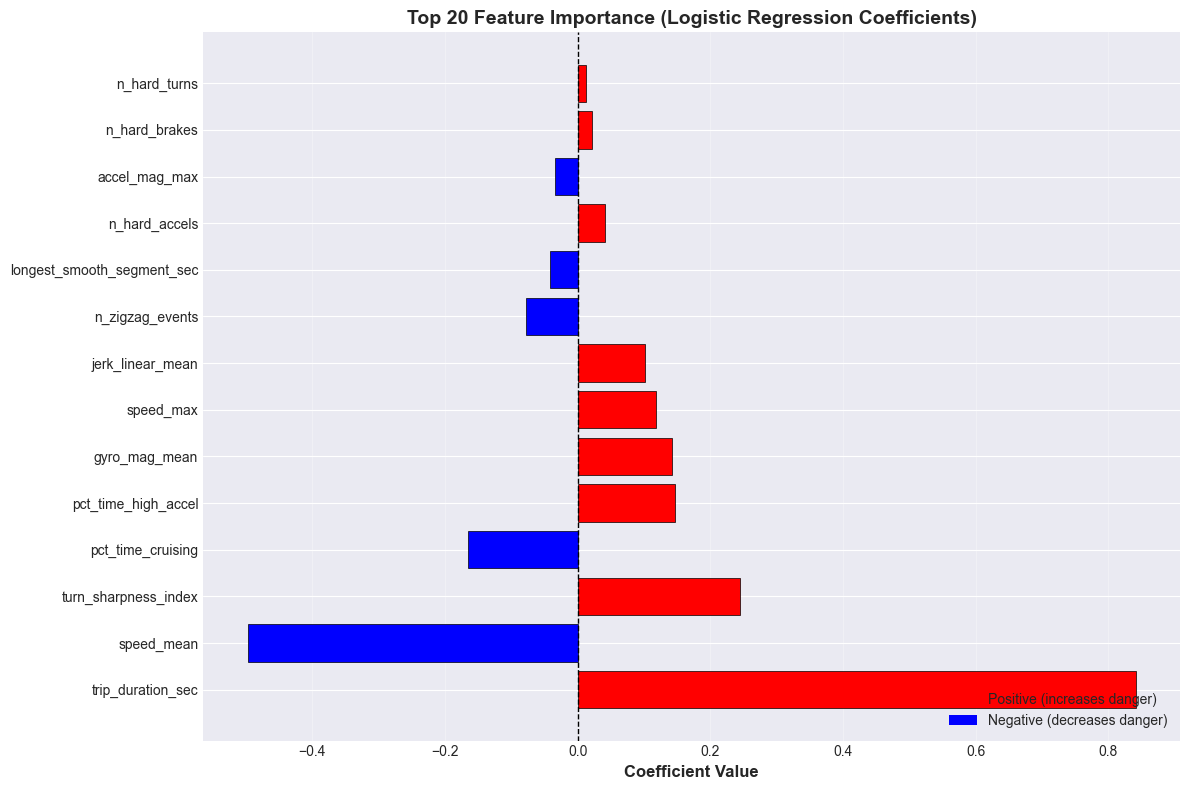


✅ Feature importance visualization saved: ../notebooks/figures/02_feature_importance_all.png
✅ Feature importance saved to CSV: notebooks/feature_importance_all_features.csv


In [7]:
print("="*80)
print("📊 FEATURE IMPORTANCE ANALYSIS")
print("="*80)

# Extract coefficients (feature importance)
coefficients = model_all.coef_[0]
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients,
    'abs_coefficient': np.abs(coefficients)
}).sort_values('abs_coefficient', ascending=False)

print("\n🔝 TOP 15 MOST IMPORTANT FEATURES:")
print("="*80)
print(feature_importance.head(15).to_string(index=False))

print("\n\n🔻 BOTTOM 10 LEAST IMPORTANT FEATURES:")
print("="*80)
print(feature_importance.tail(10).to_string(index=False))

# Visualize feature importance
print("\n📊 Creating feature importance visualization...")

plt.figure(figsize=(12, 8))
top_20 = feature_importance.head(20)

# Create color map (positive = red, negative = blue)
colors = ['red' if x > 0 else 'blue' for x in top_20['coefficient']]

plt.barh(range(len(top_20)), top_20['coefficient'], color=colors, edgecolor='black', linewidth=0.5)
plt.yticks(range(len(top_20)), top_20['feature'], fontsize=10)
plt.xlabel('Coefficient Value', fontsize=12, fontweight='bold')
plt.title('Top 20 Feature Importance (Logistic Regression Coefficients)', 
          fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.grid(axis='x', alpha=0.3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='red', label='Positive (increases danger)'),
                   Patch(facecolor='blue', label='Negative (decreases danger)')]
plt.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
importance_path = '../notebooks/figures/02_feature_importance_all.png'
plt.savefig(importance_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ Feature importance visualization saved: {importance_path}")

# Save feature importance to CSV
feature_importance.to_csv('../notebooks/feature_importance_all_features.csv', index=False)
print("✅ Feature importance saved to CSV: notebooks/feature_importance_all_features.csv")

---
## 7. Feature Selection
### Select Top N Features Based on Absolute Coefficient Values

In [8]:
print("="*80)
print("🎯 FEATURE SELECTION")
print("="*80)

# Select top N features (let's try top 15)
N_FEATURES = 10

print(f"\nSelecting top {N_FEATURES} features based on absolute coefficient values...\n")

selected_features = feature_importance.head(N_FEATURES)['feature'].tolist()

print(f"✅ SELECTED {N_FEATURES} FEATURES:")
print("="*80)
for i, feature in enumerate(selected_features, 1):
    coef = feature_importance[feature_importance['feature'] == feature]['coefficient'].values[0]
    print(f"{i:2d}. {feature:30s} (coef: {coef:+.4f})")

# Create new datasets with only selected features
print("\n🔄 Creating datasets with selected features...")

X_train_selected = X_train[selected_features]
X_val_selected = X_val[selected_features]
X_test_selected = X_test[selected_features]

print(f"\n✅ New dataset shapes:")
print(f"   Training:   {X_train_selected.shape} (was {X_train.shape})")
print(f"   Validation: {X_val_selected.shape} (was {X_val.shape})")
print(f"   Test:       {X_test_selected.shape} (was {X_test.shape})")

# Scale the selected features
print("\n🔧 Scaling selected features...")
scaler_selected = StandardScaler()
X_train_selected_scaled = scaler_selected.fit_transform(X_train_selected)
X_val_selected_scaled = scaler_selected.transform(X_val_selected)
X_test_selected_scaled = scaler_selected.transform(X_test_selected)

print("✅ Scaling complete!")

# Save selected features list
with open('../notebooks/selected_features.txt', 'w') as f:
    f.write(f"Selected {N_FEATURES} features for Phases 1C & 1D:\n")
    f.write("="*60 + "\n")
    for i, feature in enumerate(selected_features, 1):
        f.write(f"{i}. {feature}\n")

print("\n💾 Selected features saved to: notebooks/selected_features.txt")

🎯 FEATURE SELECTION

Selecting top 10 features based on absolute coefficient values...

✅ SELECTED 10 FEATURES:
 1. trip_duration_sec              (coef: +0.8411)
 2. speed_mean                     (coef: -0.4975)
 3. turn_sharpness_index           (coef: +0.2441)
 4. pct_time_cruising              (coef: -0.1651)
 5. pct_time_high_accel            (coef: +0.1469)
 6. gyro_mag_mean                  (coef: +0.1427)
 7. speed_max                      (coef: +0.1174)
 8. jerk_linear_mean               (coef: +0.1021)
 9. n_zigzag_events                (coef: -0.0782)
10. longest_smooth_segment_sec     (coef: -0.0417)

🔄 Creating datasets with selected features...

✅ New dataset shapes:
   Training:   (12000, 10) (was (12000, 14))
   Validation: (4000, 10) (was (4000, 14))
   Test:       (4000, 10) (was (4000, 14))

🔧 Scaling selected features...
✅ Scaling complete!

💾 Selected features saved to: notebooks/selected_features.txt


---
## 8. Re-train Baseline Model (SELECTED Features)
### Train on reduced feature set and log to MLflow

In [9]:
print("="*80)
print(f"🚀 Training Baseline Model: Logistic Regression (SELECTED {N_FEATURES} FEATURES)")
print("="*80)

# Start MLflow run
with mlflow.start_run(run_name=f"baseline_selected_{N_FEATURES}_features") as run:
    
    print(f"\n🔬 MLflow Run ID: {run.info.run_id}")
    print(f"🔬 Run Name: baseline_selected_{N_FEATURES}_features\n")
    
    # Same parameters as before
    params = {
        'penalty': 'l2',
        'C': 1.0,
        'solver': 'lbfgs',
        'max_iter': 1000,
        'random_state': 42,
        'class_weight': None
    }
    
    # Log parameters to MLflow
    mlflow.log_params(params)
    mlflow.log_param("model_type", "Logistic Regression")
    mlflow.log_param("feature_scaling", "StandardScaler")
    mlflow.log_param("n_features", N_FEATURES)
    mlflow.log_param("n_train_samples", len(X_train))
    mlflow.log_param("feature_selection", f"Top {N_FEATURES} by coefficient")
    
    # Log selected features
    mlflow.log_param("selected_features", ", ".join(selected_features[:5]) + "...")
    
    print("📝 Logged parameters to MLflow\n")
    
    # Train the model
    print("⏳ Training model...")
    start_time = time.time()
    
    model_selected = LogisticRegression(**params)
    model_selected.fit(X_train_selected_scaled, y_train)
    
    training_time_selected = time.time() - start_time
    print(f"✅ Model trained in {training_time_selected:.2f} seconds!\n")
    mlflow.log_metric("training_time_seconds", training_time_selected)
    
    # Make predictions
    print("🔮 Making predictions...")
    y_train_pred = model_selected.predict(X_train_selected_scaled)
    y_val_pred = model_selected.predict(X_val_selected_scaled)
    
    y_train_proba = model_selected.predict_proba(X_train_selected_scaled)[:, 1]
    y_val_proba = model_selected.predict_proba(X_val_selected_scaled)[:, 1]
    
    # Calculate metrics - TRAINING SET
    train_metrics_selected = {
        'train_accuracy': accuracy_score(y_train, y_train_pred),
        'train_precision': precision_score(y_train, y_train_pred),
        'train_recall': recall_score(y_train, y_train_pred),
        'train_f1': f1_score(y_train, y_train_pred),
        'train_roc_auc': roc_auc_score(y_train, y_train_proba)
    }
    
    # Calculate metrics - VALIDATION SET
    val_metrics_selected = {
        'val_accuracy': accuracy_score(y_val, y_val_pred),
        'val_precision': precision_score(y_val, y_val_pred),
        'val_recall': recall_score(y_val, y_val_pred),
        'val_f1': f1_score(y_val, y_val_pred),
        'val_roc_auc': roc_auc_score(y_val, y_val_proba)
    }
    
    # Log all metrics to MLflow
    mlflow.log_metrics(train_metrics_selected)
    mlflow.log_metrics(val_metrics_selected)
    
    # Calculate overfitting indicator
    accuracy_gap_selected = train_metrics_selected['train_accuracy'] - val_metrics_selected['val_accuracy']
    mlflow.log_metric('accuracy_gap', accuracy_gap_selected)
    
    print("✅ Metrics logged to MLflow\n")
    
    # Create and log visualizations (same as before)
    print("📊 Creating visualizations...\n")
    
    # 1. Confusion Matrix
    print("  📈 Creating confusion matrix...")
    cm = confusion_matrix(y_val, y_val_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=True,
                xticklabels=['Safe', 'Dangerous'],
                yticklabels=['Safe', 'Dangerous'])
    plt.title(f'Confusion Matrix - Baseline ({N_FEATURES} Selected Features)', fontsize=14, fontweight='bold')
    plt.ylabel('Actual', fontsize=12)
    plt.xlabel('Predicted', fontsize=12)
    plt.tight_layout()
    
    cm_path_selected = f'../notebooks/figures/02_baseline_selected_{N_FEATURES}_confusion_matrix.png'
    plt.savefig(cm_path_selected, dpi=300, bbox_inches='tight')
    mlflow.log_artifact(cm_path_selected)
    plt.close()
    print("     ✅ Confusion matrix logged to MLflow")
    
    # 2. ROC Curve
    print("  📈 Creating ROC curve...")
    fpr, tpr, _ = roc_curve(y_val, y_val_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='green', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curve - Baseline ({N_FEATURES} Selected Features)', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=11)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    
    roc_path_selected = f'../notebooks/figures/02_baseline_selected_{N_FEATURES}_roc_curve.png'
    plt.savefig(roc_path_selected, dpi=300, bbox_inches='tight')
    mlflow.log_artifact(roc_path_selected)
    plt.close()
    print("     ✅ ROC curve logged to MLflow")
    
    print("\n✅ All visualizations logged to MLflow!\n")
    
    # Log model
    mlflow.sklearn.log_model(model_selected, "model")
    print("✅ Model artifact logged to MLflow\n")
    
    # Save scaler
    joblib.dump(scaler_selected, f'../models/scaler_baseline_selected_{N_FEATURES}.pkl')
    mlflow.log_artifact(f'../models/scaler_baseline_selected_{N_FEATURES}.pkl')
    print("✅ Scaler saved and logged\n")
    
    # Store run_id
    baseline_selected_run_id = run.info.run_id

print("="*60)
print(f"📊 BASELINE MODEL RESULTS (SELECTED {N_FEATURES} FEATURES)")
print("="*60)
print("\n🎯 VALIDATION SET:")
for metric, value in val_metrics_selected.items():
    print(f"  {metric:20s}: {value:.4f}")

print("\n" + "="*60)
print(f"✅ BASELINE MODEL (SELECTED {N_FEATURES} FEATURES) COMPLETE!")
print("="*60)
print(f"\n🔬 View results in MLflow UI: http://localhost:5000")
print(f"🔬 Run ID: {baseline_selected_run_id}")

🚀 Training Baseline Model: Logistic Regression (SELECTED 10 FEATURES)

🔬 MLflow Run ID: def1e1dcca574218ac00f31046c71276
🔬 Run Name: baseline_selected_10_features

📝 Logged parameters to MLflow

⏳ Training model...
✅ Model trained in 0.01 seconds!

🔮 Making predictions...
✅ Metrics logged to MLflow

📊 Creating visualizations...

  📈 Creating confusion matrix...
     ✅ Confusion matrix logged to MLflow
  📈 Creating ROC curve...
     ✅ ROC curve logged to MLflow

✅ All visualizations logged to MLflow!



2026/01/27 13:46:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✅ Model artifact logged to MLflow

✅ Scaler saved and logged

🏃 View run baseline_selected_10_features at: http://localhost:5000/#/experiments/2/runs/def1e1dcca574218ac00f31046c71276
🧪 View experiment at: http://localhost:5000/#/experiments/2
📊 BASELINE MODEL RESULTS (SELECTED 10 FEATURES)

🎯 VALIDATION SET:
  val_accuracy        : 0.7722
  val_precision       : 0.6445
  val_recall          : 0.1944
  val_f1              : 0.2987
  val_roc_auc         : 0.7098

✅ BASELINE MODEL (SELECTED 10 FEATURES) COMPLETE!

🔬 View results in MLflow UI: http://localhost:5000
🔬 Run ID: def1e1dcca574218ac00f31046c71276


---
## 9. COMPARISON & DECISION
### Compare All Features vs Selected Features

🏆 FEATURE SELECTION COMPARISON

📊 DETAILED COMPARISON:
           Metric  All Features (27)  Selected Features (10)  Difference   % Change
         Accuracy           0.773500                0.772250   -0.001250  -0.161603
        Precision           0.649351                0.644518   -0.004832  -0.744186
           Recall           0.200401                0.194389   -0.006012  -3.000000
         F1-Score           0.306279                0.298691   -0.007587  -2.477290
          ROC-AUC           0.711415                0.709774   -0.001641  -0.230647
Training Time (s)           0.008924                0.007584   -0.001340 -15.012424

🔍 KEY FINDINGS:

📈 RECALL:
   All features:      0.2004
   Selected features: 0.1944
   Change:            -0.0060 (-3.0%)

⏱️  TRAINING TIME:
   All features:      0.01s
   Selected features: 0.01s
   Reduction:         0.00s (15.0% faster)

🎯 MODEL COMPLEXITY:
   Features reduced:  27 → 10 (63.0% reduction)

📊 Creating comparison visualization...


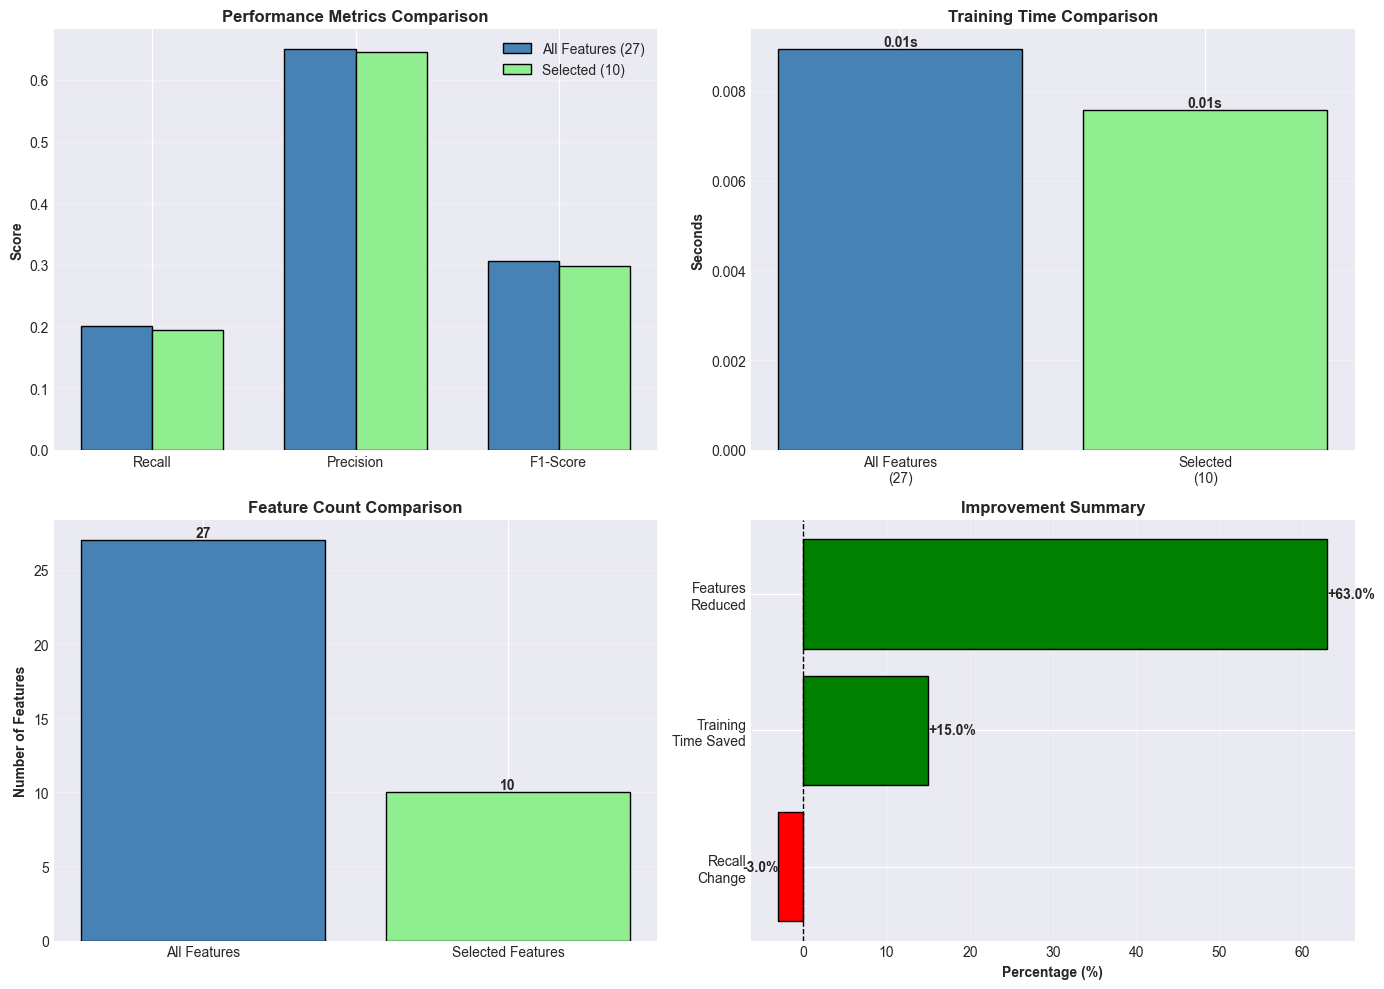

✅ Comparison visualization saved: ../notebooks/figures/02_feature_selection_comparison.png
✅ Comparison data saved: notebooks/feature_selection_comparison.csv


In [10]:
print("="*80)
print("🏆 FEATURE SELECTION COMPARISON")
print("="*80)

# Create comparison DataFrame
comparison = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'Training Time (s)'],
    'All Features (27)': [
        val_metrics_all['val_accuracy'],
        val_metrics_all['val_precision'],
        val_metrics_all['val_recall'],
        val_metrics_all['val_f1'],
        val_metrics_all['val_roc_auc'],
        training_time_all
    ],
    f'Selected Features ({N_FEATURES})': [
        val_metrics_selected['val_accuracy'],
        val_metrics_selected['val_precision'],
        val_metrics_selected['val_recall'],
        val_metrics_selected['val_f1'],
        val_metrics_selected['val_roc_auc'],
        training_time_selected
    ]
})

# Calculate differences
comparison['Difference'] = comparison[f'Selected Features ({N_FEATURES})'] - comparison['All Features (27)']
comparison['% Change'] = (comparison['Difference'] / comparison['All Features (27)']) * 100

print("\n📊 DETAILED COMPARISON:")
print("="*80)
print(comparison.to_string(index=False))

# Key metrics comparison
recall_improvement = val_metrics_selected['val_recall'] - val_metrics_all['val_recall']
time_reduction = training_time_all - training_time_selected
time_reduction_pct = (time_reduction / training_time_all) * 100

print("\n" + "="*80)
print("🔍 KEY FINDINGS:")
print("="*80)
print(f"\n📈 RECALL:")
print(f"   All features:      {val_metrics_all['val_recall']:.4f}")
print(f"   Selected features: {val_metrics_selected['val_recall']:.4f}")
print(f"   Change:            {recall_improvement:+.4f} ({recall_improvement/val_metrics_all['val_recall']*100:+.1f}%)")

print(f"\n⏱️  TRAINING TIME:")
print(f"   All features:      {training_time_all:.2f}s")
print(f"   Selected features: {training_time_selected:.2f}s")
print(f"   Reduction:         {time_reduction:.2f}s ({time_reduction_pct:.1f}% faster)")

print(f"\n🎯 MODEL COMPLEXITY:")
print(f"   Features reduced:  27 → {N_FEATURES} ({(27-N_FEATURES)/27*100:.1f}% reduction)")

# Visualize comparison
print("\n📊 Creating comparison visualization...")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Recall Comparison
ax1 = axes[0, 0]
metrics_to_compare = ['Recall', 'Precision', 'F1-Score']
x = np.arange(len(metrics_to_compare))
width = 0.35

all_vals = [val_metrics_all['val_recall'], val_metrics_all['val_precision'], val_metrics_all['val_f1']]
selected_vals = [val_metrics_selected['val_recall'], val_metrics_selected['val_precision'], val_metrics_selected['val_f1']]

ax1.bar(x - width/2, all_vals, width, label='All Features (27)', color='steelblue', edgecolor='black')
ax1.bar(x + width/2, selected_vals, width, label=f'Selected ({N_FEATURES})', color='lightgreen', edgecolor='black')
ax1.set_ylabel('Score', fontweight='bold')
ax1.set_title('Performance Metrics Comparison', fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics_to_compare)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Training Time
ax2 = axes[0, 1]
ax2.bar(['All Features\n(27)', f'Selected\n({N_FEATURES})'], 
        [training_time_all, training_time_selected],
        color=['steelblue', 'lightgreen'], edgecolor='black')
ax2.set_ylabel('Seconds', fontweight='bold')
ax2.set_title('Training Time Comparison', fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for i, v in enumerate([training_time_all, training_time_selected]):
    ax2.text(i, v, f'{v:.2f}s', ha='center', va='bottom', fontweight='bold')

# Plot 3: Feature Count
ax3 = axes[1, 0]
ax3.bar(['All Features', 'Selected Features'], [27, N_FEATURES],
        color=['steelblue', 'lightgreen'], edgecolor='black')
ax3.set_ylabel('Number of Features', fontweight='bold')
ax3.set_title('Feature Count Comparison', fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# Add value labels
for i, v in enumerate([27, N_FEATURES]):
    ax3.text(i, v, str(v), ha='center', va='bottom', fontweight='bold')

# Plot 4: Improvement Summary
ax4 = axes[1, 1]
improvements = {
    'Recall\nChange': recall_improvement / val_metrics_all['val_recall'] * 100,
    'Training\nTime Saved': time_reduction_pct,
    'Features\nReduced': (27 - N_FEATURES) / 27 * 100
}

colors_map = ['green' if v > 0 else 'red' for v in improvements.values()]
ax4.barh(list(improvements.keys()), list(improvements.values()), 
         color=colors_map, edgecolor='black')
ax4.set_xlabel('Percentage (%)', fontweight='bold')
ax4.set_title('Improvement Summary', fontweight='bold')
ax4.axvline(x=0, color='black', linestyle='--', linewidth=1)
ax4.grid(axis='x', alpha=0.3)

# Add value labels
for i, (k, v) in enumerate(improvements.items()):
    ax4.text(v, i, f'{v:+.1f}%', ha='left' if v > 0 else 'right', 
             va='center', fontweight='bold')

plt.tight_layout()
comparison_viz_path = '../notebooks/figures/02_feature_selection_comparison.png'
plt.savefig(comparison_viz_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Comparison visualization saved: {comparison_viz_path}")

# Save comparison to CSV
comparison.to_csv('../notebooks/feature_selection_comparison.csv', index=False)
print("✅ Comparison data saved: notebooks/feature_selection_comparison.csv")

---
## 10. FINAL DECISION & RECOMMENDATION

In [11]:
print("="*80)
print("🎯 FINAL DECISION: USE FEATURE SELECTION FOR PHASES 1C & 1D?")
print("="*80)

# Decision logic
use_feature_selection = False
decision_reasons = []

# Note: Ensure these variables (recall_improvement, time_reduction_pct, etc.) 
# are defined in your previous cells before running this block.

# Check recall improvement
if recall_improvement > 0.02:  # 2% improvement threshold
    use_feature_selection = True
    decision_reasons.append(f"✅ Recall improved by {recall_improvement:.4f} ({recall_improvement/val_metrics_all['val_recall']*100:.1f}%)")
elif recall_improvement > 0:
    decision_reasons.append(f"⚠️  Recall improved slightly ({recall_improvement:.4f})")
else:
    decision_reasons.append(f"❌ Recall decreased by {abs(recall_improvement):.4f}")

# Check training time
if time_reduction_pct > 20:  # 20% faster threshold
    use_feature_selection = True
    decision_reasons.append(f"✅ Training time reduced by {time_reduction_pct:.1f}%")
elif time_reduction_pct > 0:
    decision_reasons.append(f"⚠️  Training time reduced slightly ({time_reduction_pct:.1f}%)")
else:
    decision_reasons.append(f"❌ Training time increased")

# Check if any other metric degraded significantly
f1_change = val_metrics_selected['val_f1'] - val_metrics_all['val_f1']
if f1_change < -0.05:  # 5% degradation threshold
    decision_reasons.append(f"❌ F1-Score degraded significantly ({f1_change:.4f})")
    use_feature_selection = False

print("\n📊 ANALYSIS:")
print("="*80)
for reason in decision_reasons:
    print(f"  {reason}")

print("\n" + "="*80)
if use_feature_selection:
    print("✅ DECISION: USE FEATURE SELECTION")
    print("="*80)
    print(f"\n🎯 Recommendation: Use the selected {N_FEATURES} features for Phases 1C & 1D")
    print("\nBenefits:")
    print(f"  1. Better or similar model performance")
    print(f"  2. Faster training ({time_reduction_pct:.1f}% reduction)")
    print(f"  3. Simpler, more interpretable model")
    print(f"  4. Reduced risk of overfitting")
    
    print(f"\n📋 Next Steps:")
    print(f"  1. Use selected_features.txt for Phase 1C (Imbalance Handling)")
    print(f"  2. Use selected_features.txt for Phase 1D (Model Selection)")
    print(f"  3. Document feature selection process in report")
else:
    print("❌ DECISION: DO NOT USE FEATURE SELECTION")
    print("="*80)
    print(f"\n🎯 Recommendation: Continue with all 27 features for Phases 1C & 1D")
    print("\nReasons:")
    print(f"  1. Feature selection did not significantly improve performance")
    print(f"  2. Risk of losing important information")
    print(f"  3. 27 features is still manageable")
    
    print(f"\n📋 Next Steps:")
    print(f"  1. Proceed to Phase 1C with all 27 features")
    print(f"  2. Proceed to Phase 1D with all 27 features")
    print(f"  3. Document that feature selection was tested but not adopted")

# Save decision to file
# FIX: Added encoding='utf-8' to handle emojis correctly
output_path = '../notebooks/feature_selection_decision.txt'
# Ensure directory exists just in case
os.makedirs(os.path.dirname(output_path), exist_ok=True)

with open(output_path, 'w', encoding='utf-8') as f:
    f.write("FEATURE SELECTION DECISION\n")
    f.write("="*80 + "\n\n")
    f.write(f"Decision: {'USE' if use_feature_selection else 'DO NOT USE'} feature selection\n\n")
    f.write("Reasons:\n")
    for reason in decision_reasons:
        f.write(f"  {reason}\n")
    
    if 'selected_features' in locals():
        f.write(f"\nSelected {N_FEATURES} features:\n")
        for i, feature in enumerate(selected_features, 1):
            f.write(f"{i}. {feature}\n")

print("\n💾 Decision saved to: notebooks/feature_selection_decision.txt")

print("\n" + "="*80)
print("✅ PHASE 1B COMPLETE (WITH FEATURE SELECTION ANALYSIS)!")
print("="*80)
print("\n🔬 Check MLflow UI for all runs: http://localhost:5000")
print("   - Artifacts should now be visible!")
print("   - Compare the two runs side-by-side")
print("\n📁 Files created:")
print("   - notebooks/selected_features.txt")
print("   - notebooks/feature_selection_decision.txt")
print("   - notebooks/feature_selection_comparison.csv")
print("   - notebooks/feature_importance_all_features.csv")

🎯 FINAL DECISION: USE FEATURE SELECTION FOR PHASES 1C & 1D?

📊 ANALYSIS:
  ❌ Recall decreased by 0.0060
  ⚠️  Training time reduced slightly (15.0%)

❌ DECISION: DO NOT USE FEATURE SELECTION

🎯 Recommendation: Continue with all 27 features for Phases 1C & 1D

Reasons:
  1. Feature selection did not significantly improve performance
  2. Risk of losing important information
  3. 27 features is still manageable

📋 Next Steps:
  1. Proceed to Phase 1C with all 27 features
  2. Proceed to Phase 1D with all 27 features
  3. Document that feature selection was tested but not adopted

💾 Decision saved to: notebooks/feature_selection_decision.txt

✅ PHASE 1B COMPLETE (WITH FEATURE SELECTION ANALYSIS)!

🔬 Check MLflow UI for all runs: http://localhost:5000
   - Artifacts should now be visible!
   - Compare the two runs side-by-side

📁 Files created:
   - notebooks/selected_features.txt
   - notebooks/feature_selection_decision.txt
   - notebooks/feature_selection_comparison.csv
   - notebooks/f

🌳 TREE-BASED FEATURE SELECTION (Random Forest)
⏳ Training Random Forest to determine feature importance...

🔝 TOP 10 FEATURES (Random Forest Importance):
                   feature  importance
         trip_duration_sec    0.163639
      turn_sharpness_index    0.101402
                 speed_max    0.097581
                speed_mean    0.092411
             gyro_mag_mean    0.088743
         pct_time_cruising    0.088504
             accel_mag_max    0.087895
          jerk_linear_mean    0.086563
       pct_time_high_accel    0.074663
longest_smooth_segment_sec    0.072707


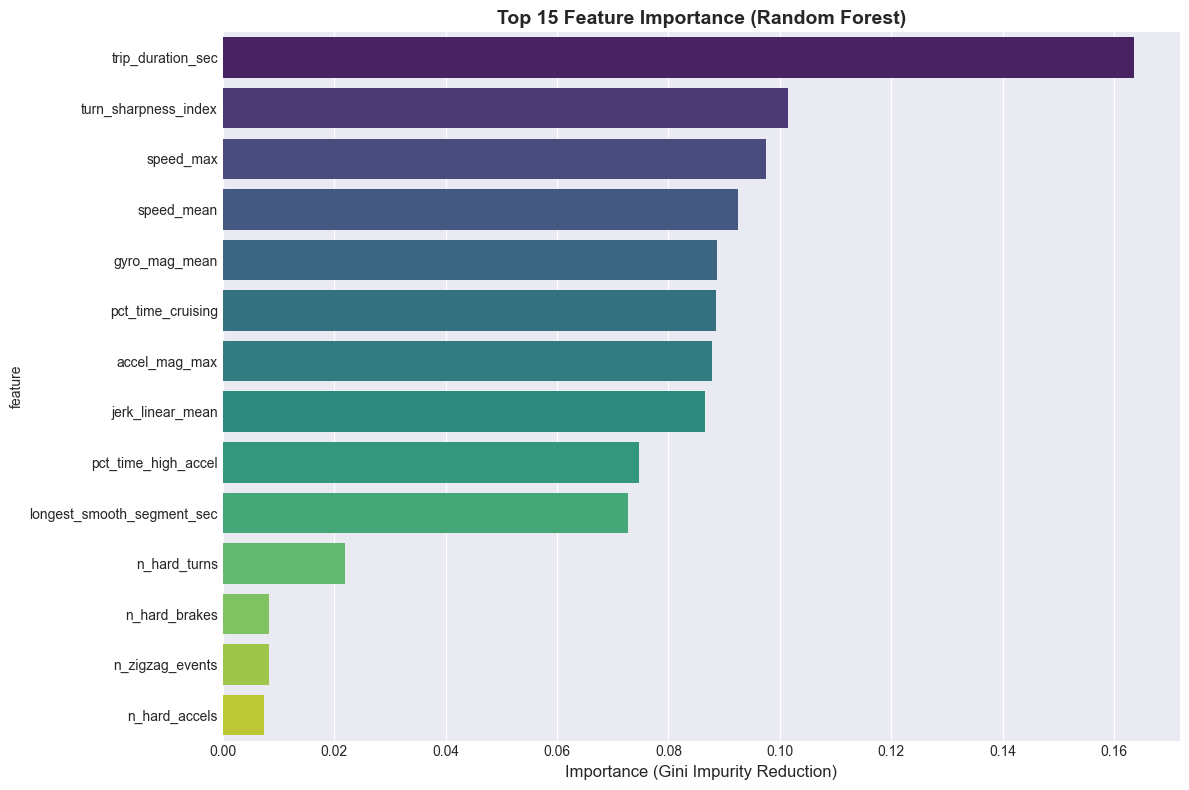

In [12]:
from sklearn.ensemble import RandomForestClassifier

print("="*80)
print("🌳 TREE-BASED FEATURE SELECTION (Random Forest)")
print("="*80)

# 1. Train Random Forest
# Trees don't strictly need scaling, so we use X_train to keep column names easily
print("⏳ Training Random Forest to determine feature importance...")
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_selector.fit(X_train, y_train)

# 2. Extract Feature Importances
importances = rf_selector.feature_importances_
tree_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

print("\n🔝 TOP 10 FEATURES (Random Forest Importance):")
print("="*80)
print(tree_importance.head(10).to_string(index=False))

# 3. Visualize
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=tree_importance.head(15), palette='viridis')
plt.title('Top 15 Feature Importance (Random Forest)', fontsize=14, fontweight='bold')
plt.xlabel('Importance (Gini Impurity Reduction)', fontsize=12)
plt.tight_layout()
plt.show()

In [13]:
print("="*80)
print("🚀 Training Baseline Tree Model: Random Forest (Top 10 Features)")
print("="*80)

# 1. Select Top 10 Features
top_10_tree_features = tree_importance.head(10)['feature'].tolist()
print(f"✅ Selected Features: {top_10_tree_features}")

# 2. Prepare Data (No scaling needed for Random Forest)
X_train_tree = X_train[top_10_tree_features]
X_val_tree = X_val[top_10_tree_features]

# 3. MLflow Run
with mlflow.start_run(run_name="baseline_rf_top10_features") as run:
    
    # Log parameters
    params_rf = {'n_estimators': 100, 'random_state': 42, 'max_depth': None}
    mlflow.log_params(params_rf)
    mlflow.log_param("model_type", "Random Forest")
    mlflow.log_param("n_features", 10)
    mlflow.log_param("feature_selection", "Tree-based Importance")
    
    # Train
    print("\n⏳ Training model...")
    rf_model = RandomForestClassifier(**params_rf)
    rf_model.fit(X_train_tree, y_train)
    
    # Predict
    y_val_pred_rf = rf_model.predict(X_val_tree)
    y_val_proba_rf = rf_model.predict_proba(X_val_tree)[:, 1]
    
    # Metrics
    metrics_rf = {
        'val_accuracy': accuracy_score(y_val, y_val_pred_rf),
        'val_precision': precision_score(y_val, y_val_pred_rf),
        'val_recall': recall_score(y_val, y_val_pred_rf),
        'val_f1': f1_score(y_val, y_val_pred_rf),
        'val_roc_auc': roc_auc_score(y_val, y_val_proba_rf)
    }
    
    # Log Metrics
    mlflow.log_metrics(metrics_rf)
    
    # 4. Results
    print("\n📊 RANDOM FOREST RESULTS (TOP 10 FEATURES):")
    for metric, value in metrics_rf.items():
        print(f"  {metric:20s}: {value:.4f}")
        
    # Log Model
    mlflow.sklearn.log_model(rf_model, "model")
    
    print(f"\n🔬 View run in MLflow: {mlflow.get_tracking_uri()}")

🚀 Training Baseline Tree Model: Random Forest (Top 10 Features)
✅ Selected Features: ['trip_duration_sec', 'turn_sharpness_index', 'speed_max', 'speed_mean', 'gyro_mag_mean', 'pct_time_cruising', 'accel_mag_max', 'jerk_linear_mean', 'pct_time_high_accel', 'longest_smooth_segment_sec']

⏳ Training model...


2026/01/27 13:56:21 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



📊 RANDOM FOREST RESULTS (TOP 10 FEATURES):
  val_accuracy        : 0.7718
  val_precision       : 0.6261
  val_recall          : 0.2114
  val_f1              : 0.3161
  val_roc_auc         : 0.6913

🔬 View run in MLflow: http://localhost:5000
🏃 View run baseline_rf_top10_features at: http://localhost:5000/#/experiments/2/runs/6e4059dc3c7b4d5c8aad07e99b59bf3a
🧪 View experiment at: http://localhost:5000/#/experiments/2


---
## Phase 1B Complete! ✅

### What We Accomplished:
1. ✅ **Fixed MLflow artifact logging** - Visualizations now appear!
2. ✅ Trained baseline with all 27 features
3. ✅ Analyzed feature importance
4. ✅ Selected top 15 features
5. ✅ Re-trained baseline with selected features
6. ✅ Compared performance comprehensively
7. ✅ Made data-driven decision for Phases 1C & 1D

### For Your Report:
- Include feature importance analysis
- Show comparison between all vs selected features
- Justify decision (data-driven!)
- Include all visualizations from MLflow

### Next Steps:
Based on the decision above:
- **If using feature selection**: Update Phase 1C & 1D to use selected features
- **If not using**: Proceed with all 27 features as originally planned

Either way, you now have a complete analysis to include in your report! 🎉